In [1]:
# pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report 
from xgboost import XGBClassifier


%matplotlib inline
pio.renderers.default='iframe'

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [3]:
df = pd.read_pickle("../../data_lake/output/train.pkl")
val = pd.read_pickle("../../data_lake/output/val.pkl")

# 2.0 EDA

In [4]:
df = df.drop(columns=['dist2','customer_id','TransactionID'])
val = val.drop(columns=['dist2','customer_id','TransactionID'])

In [5]:
df = df.rename(columns={'id_31':'browser'})
val = val.rename(columns={'id_31':'browser'})

In [6]:
df['P_emaildomain'] = df['P_emaildomain'].mask(df['P_emaildomain']=='gmail','gmail.com')
val['P_emaildomain'] = val['P_emaildomain'].mask(val['P_emaildomain']=='gmail','gmail.com')

In [7]:
df['R_emaildomain'] = df['R_emaildomain'].mask(df['R_emaildomain']=='gmail','gmail.com')
val['R_emaildomain'] = val['R_emaildomain'].mask(val['R_emaildomain']=='gmail','gmail.com')

In [8]:
df['id_30'] = df['id_30'].replace(" ","_",regex=True)
df['id_30'] = df['id_30'].str.replace(".","_",regex=False)

In [9]:
val['id_30'] = val['id_30'].replace(" ","_",regex=True)
val['id_30'] = val['id_30'].str.replace(".","_",regex=False)

In [10]:
df['browser'] = df['browser'].mask(df['browser'].str.contains('SM') | df['browser'].str.contains('ZTE'),'other')
val['browser'] = val['browser'].mask(val['browser'].str.contains('SM') | val['browser'].str.contains('ZTE'),'other')

In [11]:
df['browser'] = df['browser'].astype(str)
val['browser'] = val['browser'].astype(str)

In [12]:
df['browser_enc'] = 'other'
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('ie'),'ie')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('safari'),'safari')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('edge'),'edge')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('firefox'),'firefox')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('android'),'android')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('Android'),'android')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('chrome'),'chrome')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('opera'),'opera')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('google'),'chrome')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('samsung'),'android')

In [13]:
val['browser_enc'] = 'other'
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('ie'),'ie')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('safari'),'safari')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('edge'),'edge')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('firefox'),'firefox')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('android'),'android')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('Android'),'android')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('chrome'),'chrome')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('opera'),'opera')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('google'),'chrome')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('samsung'),'android')

In [14]:
df['DeviceType'] = df['DeviceType'].mask(df['browser']== 'ie 11.0 for tablet','tablet')
val['DeviceType'] = val['DeviceType'].mask(val['browser']== 'ie 11.0 for tablet','tablet')

In [15]:
df = df.drop(columns='browser')
val = val.drop(columns='browser')

In [16]:
df['device_info'] = df['DeviceInfo'].replace("-","_",regex=True)
df['device_info2'] = df['device_info'].replace(" ","_",regex=True)
df['device_info'] = df['DeviceInfo'].replace("-","_",regex=True)
df['device_info2'] = df['device_info'].replace(" ","_",regex=True)
df['device_info3'] = df['device_info2'].str.split("_").str[0]
df['device_info3'] = df['device_info3'].str.lower()

In [17]:
val['device_info'] = val['DeviceInfo'].replace("-","_",regex=True)
val['device_info2'] = val['device_info'].replace(" ","_",regex=True)
val['device_info'] = val['DeviceInfo'].replace("-","_",regex=True)
val['device_info2'] = val['device_info'].replace(" ","_",regex=True)
val['device_info3'] = val['device_info2'].str.split("_").str[0]
val['device_info3'] = val['device_info3'].str.lower()

In [18]:
df['device_info_v4'] = 'other'
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='windows') | (df['device_info3']=='microsoft') | (df['device_info3']=='trident/7.0')),'windows')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='ios') | (df['device_info3']=='iphone')),'ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='blade','blade')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='lenovo','lenovo')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='redmi','redmi')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='pixel','pixel')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='android','android')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='alcatel','alcatel')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='nokia','nokia')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='asus','asus')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='oneplus','oneplus')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='zte','zte')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='hisense','hisense')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='linux','linux')
df['device_info_v4'] = df['device_info_v4'].mask((df['device_info3'].str.contains("lg") | (df['device_info3'].str.contains("nexus"))),'lg')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3'].str.contains("huawei")) | (df['device_info3'].str.contains("hi6210sft"))),'huawei')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='motog3') |(df['device_info3']=='moto')),'moto')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='sm') |(df['device_info3']=='samsung')),'samsung')

In [19]:
val['device_info_v4'] = 'other'
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='windows') | (val['device_info3']=='microsoft') | (val['device_info3']=='trident/7.0')),'windows')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='ios') | (val['device_info3']=='iphone')),'ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='blade','blade')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='lenovo','lenovo')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='redmi','redmi')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='pixel','pixel')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='android','android')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='alcatel','alcatel')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='nokia','nokia')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='asus','asus')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='oneplus','oneplus')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='zte','zte')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='hisense','hisense')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='linux','linux')
val['device_info_v4'] = val['device_info_v4'].mask((val['device_info3'].str.contains("lg") | (val['device_info3'].str.contains("nexus"))),'lg')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3'].str.contains("huawei")) | (val['device_info3'].str.contains("hi6210sft"))),'huawei')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='motog3') |(val['device_info3']=='moto')),'moto')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='sm') |(val['device_info3']=='samsung')),'samsung')

In [20]:
df = df.drop(columns=['device_info','device_info2','device_info3','DeviceInfo'])
val = val.drop(columns=['device_info','device_info2','device_info3','DeviceInfo'])

In [21]:
df = df.drop(columns=['card1', 'card2', 'card3','card5', 'card6','M4', 'id_21', 'id_22',
                      'id_23','id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38']) #'
val = val.drop(columns=['card1', 'card2', 'card3','card5', 'card6','M4', 'id_21', 'id_22',
                        'id_23','id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38'])# 

In [22]:
def model_training(X_train, y_train, numerical_cols, categorical_cols,parameters):
    """
    
    """
    
    ##
    numerical_preprocessor = Pipeline(steps=[("imputer", IterativeImputer(ExtraTreesRegressor(n_estimators=5,random_state=1,verbose=0),random_state=1,verbose=0,add_indicator=True)),
                                     ("scaler", MinMaxScaler())])
    categorical_preprocessor = Pipeline(steps=[("imputer", SimpleImputer(strategy='constant', fill_value='missing',verbose=0,add_indicator=True)),
                                           ("label_enc", OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(transformers=[("numerical_preprocessor", numerical_preprocessor, numerical_cols),
                                               ("categorical_preprocessor", categorical_preprocessor, categorical_cols)])
    pipe_model = XGBClassifier(random_state=2, objective='binary:logistic')
    ##
    model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', pipe_model)])
    ##
    model.fit(X_train,y_train)
    model_grid = GridSearchCV(model,parameters,cv=4,scoring='accuracy',verbose=0,return_train_score=True).fit(X_train,y_train)
    print('GridSearchCV results...')
    print("Mean Train Scores: \n{}\n".format(model_grid.cv_results_['mean_train_score']))
    print("Mean CV Scores: \n{}\n".format(model_grid.cv_results_['mean_test_score']))
    print("Best Parameters: \n{}\n".format(model_grid.best_params_))
    
    return model_grid

In [23]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [24]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [25]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [26]:
parameters = {'model__n_estimators':[200,500,700]}

In [27]:
model = model_training(X_train,y_train,numerical_cols,categorical_cols,parameters)

GridSearchCV results...
Mean Train Scores: 
[0.92510686 0.9790706  0.99011668]

Mean CV Scores: 
[0.83374823 0.84153477 0.84234438]

Best Parameters: 
{'model__n_estimators': 700}



In [28]:
def model_evaluation(model,X_test,y_test):
    """
    
    """
    print('Test results...')
    y_test_predict_grid = model.predict(X_test)    
    print("Model Test Accuracy:", metrics.accuracy_score(y_test, y_test_predict_grid))
    print('--------------------------------------------------')
    print('Model Test Confusion Matrix')
    cm = confusion_matrix(y_test,y_test_predict_grid,normalize='true') 
    cmd = ConfusionMatrixDisplay(cm,display_labels=['No','Yes'])
    cmd.plot()
    print('Classification report : \n',classification_report(y_test, y_test_predict_grid))

    ##
    feature_importances = model.best_estimator_.named_steps['model'].feature_importances_
    feature_names = X_test.columns
    lista = []
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    #         print('{}: {}'.format(name, score))
            lista.append(name)
    print('First ten features by importances:')
    print(lista[0:15])
    
    return model

In [29]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [30]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

Test results...
Model Test Accuracy: 0.8534781603882597
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.99      0.85      0.91     19976
         1.0       0.33      0.85      0.47      1659

    accuracy                           0.85     21635
   macro avg       0.66      0.85      0.69     21635
weighted avg       0.94      0.85      0.88     21635

First ten features by importances:
['ProductCD', 'id_33', 'id_30', 'DeviceType', 'id_32', 'card4', 'TransactionAmt', 'device_info_v4', 'R_emaildomain', 'id_34', 'max_d', 'max_c', 'num_transactio_per_time', 'addr1', 'browser_enc']


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_preprocessor',
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer(add_indicator=True,
                                                                                                           estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                                         random_state=1),
                                                                                                           random_state=1)),
                                                                                         ('scaler',
                                                                  

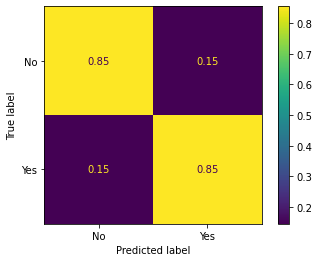

In [31]:
model_evaluation(model,X_val,y_val)

In [32]:
df['proba'] = model.predict_proba(df[X_train.columns])[:,1]
val['proba'] = model.predict_proba(val[X_train.columns])[:,1]

In [33]:
val.sample(3)

,isFraud,TransactionAmt,ProductCD,card4,addr1,addr2,P_emaildomain,R_emaildomain,id_30,id_32,id_33,id_34,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
134113,0,39.962,C,visa,nan,nan,gmail.com,gmail.com,nan,nan,nan,nan,mobile,1.0,0.0,1,0,chrome,samsung,0.336236
120146,0,50.000,H,visa,122.0,87.0,gmail.com,gmail.com,Mac_OS_X_10_12_6,24.0,3360x2100,match_status:2,desktop,1.0,0.0,1,0,safari,ios,0.043807
92374,0,86.038,C,mastercard,nan,nan,gmail.com,gmail.com,nan,nan,nan,nan,desktop,1.0,535.0,1,0,chrome,windows,0.821087


In [34]:
df.sample(3)

,isFraud,TransactionAmt,ProductCD,card4,addr1,addr2,P_emaildomain,R_emaildomain,id_30,id_32,id_33,id_34,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
81700,1,90.000,S,american express,123.0,87.0,nan,gmail.com,Android,24.0,855x480,match_status:2,mobile,27.0,17.000000,1,0,chrome,other,0.998193
88323,1,18.851,C,visa,nan,nan,gmail.com,gmail.com,nan,nan,nan,nan,desktop,17.0,43.000000,1,0,chrome,other,0.987585
52555,0,100.000,H,visa,nan,nan,gmail.com,gmail.com,Windows_10,24.0,2160x1440,match_status:2,desktop,1.0,29.583332,1,0,chrome,windows,0.366864


In [35]:
val['isFraud'].value_counts()

0    19976
1     1659
Name: isFraud, dtype: int64

In [36]:
val[val['isFraud']=='1'].sample(3)

,isFraud,TransactionAmt,ProductCD,card4,addr1,addr2,P_emaildomain,R_emaildomain,id_30,id_32,id_33,id_34,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
111797,1,26.682,C,visa,nan,nan,gmail.com,gmail.com,nan,nan,nan,nan,desktop,51.0,438.000000,1,0,chrome,windows,0.966457
76557,1,33.534,C,mastercard,nan,nan,hotmail.com,hotmail.com,nan,nan,nan,nan,desktop,278.0,297.000000,1,0,chrome,other,0.999713
70267,1,26.818,C,mastercard,nan,nan,hotmail.com,hotmail.com,nan,nan,nan,nan,mobile,15.0,67.958336,1,0,chrome,other,0.941250
